# Part C

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/fin_econometrics_2/project1`


In [2]:
Pkg.instantiate()

Status `~/Documents/fin_econometrics_2/project1/Project.toml`
  [6d3278bc] ARCHModels v2.3.4
  [fbb218c0] BSON v0.3.7
  [ad839575] Blink v0.12.8
  [336ed68f] CSV v0.10.11
  [a93c6f00] DataFrames v1.6.1
⌃ [1313f7d8] DataFramesMeta v0.14.0
⌃ [31c24e10] Distributions v0.25.102
  [587475ba] Flux v0.14.6
⌃ [38e38edf] GLM v1.8.3
  [c601a237] Interact v0.10.5
  [945b72a4] MarketData v0.13.12
  [429524aa] Optim v1.7.8
  [91a5bcdd] Plots v1.39.0
  [ce6b1742] RDatasets v0.7.7
  [b0e4dd01] RollingFunctions v0.8.0
⌅ [2913bbd2] StatsBase v0.33.21
  [f3b207a7] StatsPlots v0.15.6
  [bd369af6] Tables v1.11.1
  [9e3dc215] TimeSeries v0.23.2
  [e88e6eb3] Zygote v0.6.67
  [37e2e46d] LinearAlgebra
  [10745b16] Statistics v1.9.0
Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


In [3]:
include("project_functions.jl")

trainW4 (generic function with 1 method)

In [5]:
using Statistics, DataFrames, StatsPlots, TimeSeries, KernelDensity, RollingFunctions, DataFramesMeta, MarketData, Dates

## Data Preperation

We will load daily data of the Pfizer stock as it ought to be interesting to study volatility of a company which presumably was influenced greatly by the COVID19 virus.

In [6]:
PFE = yahoo("PFE", YahooOpt(period1 = DateTime(2010, 1, 1), period2 = now()))

3494×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2010-01-04 to 2023-11-17
│            │ Open    │ High    │ Low     │ Close   │ AdjClose │ Volume      │
├────────────┼─────────┼─────────┼─────────┼─────────┼──────────┼─────────────┤
│ 2010-01-04 │ 17.334  │ 17.9696 │ 17.3055 │ 17.9602 │ 10.6451  │ 5.4898644e7 │
│ 2010-01-05 │ 17.9507 │ 17.9602 │ 17.5996 │ 17.704  │ 10.4932  │ 4.5714931e7 │
│ 2010-01-06 │ 17.704  │ 17.8463 │ 17.5617 │ 17.6471 │ 10.4595  │ 4.3640975e7 │
│ 2010-01-07 │ 17.685  │ 17.7135 │ 17.5142 │ 17.5806 │ 10.4201  │ 4.1557112e7 │
│ 2010-01-08 │ 17.666  │ 17.7514 │ 17.5712 │ 17.723  │ 10.5045  │ 3.2049716e7 │
│ 2010-01-11 │ 17.8653 │ 17.9791 │ 17.7135 │ 17.8653 │ 10.5888  │ 3.4199665e7 │
│ 2010-01-12 │ 17.8368 │ 18.0171 │ 17.685  │ 17.8084 │ 10.5551  │ 4.3501847e7 │
│ 2010-01-13 │ 17.9032 │ 18.3112 │ 17.9032 │ 18.2258 │ 10.8025  │ 6.2728072e7 │
│ ⋮          │ ⋮       │ ⋮       │ ⋮       │ ⋮       │ ⋮        │ ⋮           │
│ 2023-11-09 │ 30.49   │ 30.51   │ 29.63   

PLease note in the underneath transformations that both realized variance and realized volatility is considered. Namely, literature illustrates the usage of both with regards to HAR estimation as well as HAR forecasting.

Where Realized Variance can be denoted as:

$$ RV = \sum_{i=1}^n(r_i)^2  $$

And Realized Volatility as:

$$ RV = \sqrt{\sum_{i=1}^n(r_i)^2} $$

$r_i$ is the log return at time $i$, and $n$ is the number of observations.

In [8]:
df = DataFrame(PFE)
df = @transform(df, :ln_returns = [NaN; diff(log.(:AdjClose))]) #logarithmic returns of the closing price
df = @transform(df, :r_var = running(sum,:ln_returns .^2, 20)) #rolling sum of squared returns over a window of 20 observations
df = @transform(df, :r_vol = sqrt.(:r_var)) #Realized Volatility, square root of rolling variance
df = df[31:end,:]
first(df, 5)

5×10 DataFrame
 Row │ timestamp   Open     High     Low      Close    AdjClose  Volume     ln ⋯
     │ Date        Float64  Float64  Float64  Float64  Float64   Float64    Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2010-02-17  16.9355  16.945   16.6319  16.7647   10.0304  6.13998e7  -0 ⋯
   2 │ 2010-02-18  16.7742  16.8406  16.6509  16.8216   10.0644  6.02029e7   0
   3 │ 2010-02-19  16.907   17.1727  16.8216  17.0683   10.212   5.33933e7   0
   4 │ 2010-02-22  17.0588  17.2201  16.8691  17.0304   10.1893  6.1134e7   -0
   5 │ 2010-02-23  16.926   17.0209  16.7078  16.7647   10.0304  5.04584e7  -0 ⋯
                                                               3 columns omitted

#### HAR

Let us first consider the HAR model:
$$ RV_t = \beta_0 + \beta_1  RV_{d,t} + \beta_2  RV_{w,t} + \beta_3  RV_{m,t} + \epsilon_t $$
where $RV_t$ can be denoted as:
realized variance, $RV_t = \sigma_t^2 $ or
realized volatility, $ RV_t = \sqrt{\sigma_t^2} $

Hence, we will first calculate daily, weekly and monthly Realized Volatilities:

In [9]:
HAR_regressors(df.r_vol)

3442×3 Matrix{Float64}:
 0.0403491  0.0403108  0.0494387
 0.0420424  0.0408109  0.0483046
 0.0442857  0.0415242  0.0472715
 0.0471132  0.042853   0.0467527
 0.046618   0.0440817  0.0462942
 0.0478077  0.0455734  0.0458056
 0.0493166  0.0470283  0.0453669
 0.0486815  0.0479074  0.0449342
 0.0479501  0.0480748  0.0445979
 0.0456389  0.047879   0.0441053
 ⋮                     
 0.0822953  0.0808596  0.0750682
 0.0823209  0.081079   0.0760744
 0.0834591  0.0819068  0.077162
 0.0867335  0.0834182  0.0784128
 0.0833533  0.0836324  0.0795102
 0.0773366  0.0826407  0.080323
 0.0763233  0.0814411  0.0808641
 0.0711265  0.0789746  0.0808043
 0.0721515  0.0760582  0.0807471

We can now identify the predictors and target for our study.

In [10]:
predictors = HAR_regressors(df.r_vol)
target = df.r_vol[23:end]
size(predictors), size(target)

((3442, 3), (3442,))

In [11]:
using Flux

In [13]:
xtrain = predictors[1:2750,:] |> permutedims .|> Float32
ytrain = target[1:2750] |> permutedims .|> Float32
xvalid = predictors[2751:3442,:] |> permutedims .|> Float32
yvalid = target[2751:3442] |> permutedims .|> Float32;

Note for self, the above transposes the matrices and converts the elements to 32-bit floating-point numbers.  

We now further standardize the data using ZScoreTransform.

In [14]:
using StatsBase

standardization of data:

In [15]:
fit_xt = StatsBase.fit(ZScoreTransform, log.(xtrain); dims=2, center=true, scale=true)
fit_xv = StatsBase.fit(ZScoreTransform, log.(xvalid); dims=2, center=true, scale=true)
fit_yt = StatsBase.fit(ZScoreTransform, log.(ytrain); dims=2, center=true, scale=true)
fit_yv = StatsBase.fit(ZScoreTransform, log.(yvalid); dims=2, center=true, scale=true)

ZScoreTransform{Float32, Vector{Float32}}(1, 2, Float32[-2.7632768], Float32[0.3454386])

ZScoreTransform is a standardization method used to transform data into a standard normal distribution with a mean of 0 and a standard deviation of 1.

In [16]:
xt_std = StatsBase.transform(fit_xt, log.(xtrain))
xv_std = StatsBase.transform(fit_xv, log.(xvalid))
yt_std = StatsBase.transform(fit_yt, log.(ytrain))
yv_std = StatsBase.transform(fit_yv, log.(yvalid))

1×692 Matrix{Float32}:
 -0.873087  -1.07666  -1.06013  -1.90018  …  0.34733  0.388752  0.308799

## FFNN

Now we implement the ffnn model specified in our project_functions.jl file. Note that this is the trainW3() function from the seminar with a few tweeks and changes:
- Usage of batch normalization, 
- Addition of verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0 similar to the trained model from seminar 4,
- an additional layer represented by the nodes
- different values for minimizing MSE

In [75]:
FFNN, losses11, losses12 = ffnn(xt_std, yt_std, xv_std, yv_std; nodes=[100, 50, 30], eta=0.001,
n_epochs=500, verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0);

Epoch 30 	 Loss: 0.121869154 	 Test: 0.11923372
Epoch 60 	 Loss: 

0.040406972 	 Test: 0.0518604


Epoch 90 	 Loss: 0.03140827 	 Test: 0.04368839
Epoch 120 	 Loss: 

0.030307457 	 Test: 0.042761862


Epoch 150 	 Loss: 0.029764185 	 Test: 0.042385727
Epoch 180 	 Loss: 

0.029371172 	 Test: 0.042094626


Epoch 210 	 Loss: 0.029061537 	 Test: 0.041883186
Epoch 240 	 Loss: 

0.028818082 	 Test: 0.041654326


Epoch 270 	 Loss: 0.028582422 	 Test: 0.041542586
Epoch 300 	 Loss: 

0.028386075 	 Test: 0.04151184


Epoch 330 	 Loss: 0.02820688 	 Test: 0.04136484
Stopping early. No improvement in validation loss for 20 epochs.

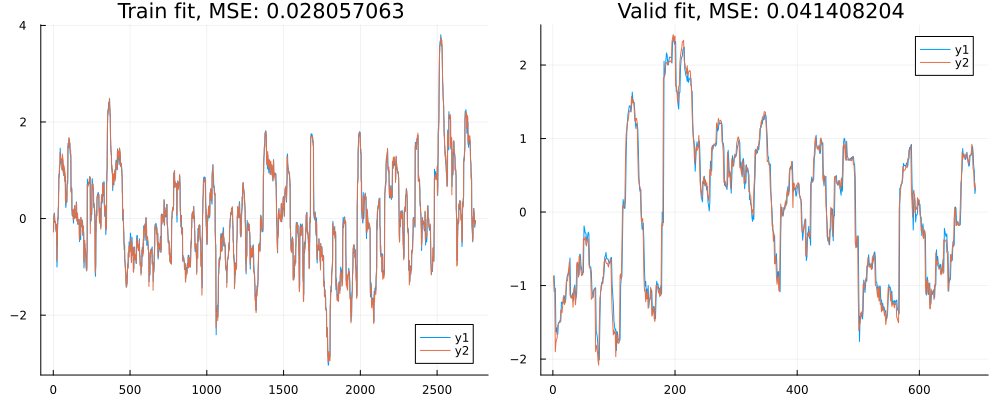

In [76]:
p1 = plot(FFNN(xt_std)', title="Train fit, MSE: $(Flux.Losses.mse(FFNN(xt_std),yt_std)) ",)
p1 = plot!(yt_std')
#
p2 = plot(FFNN(xv_std)', title="Valid fit, MSE: $(Flux.Losses.mse(FFNN(xv_std),yv_std)) ",)
p2 = plot!(yv_std');
plot(p1, p2, size=(1000, 400))

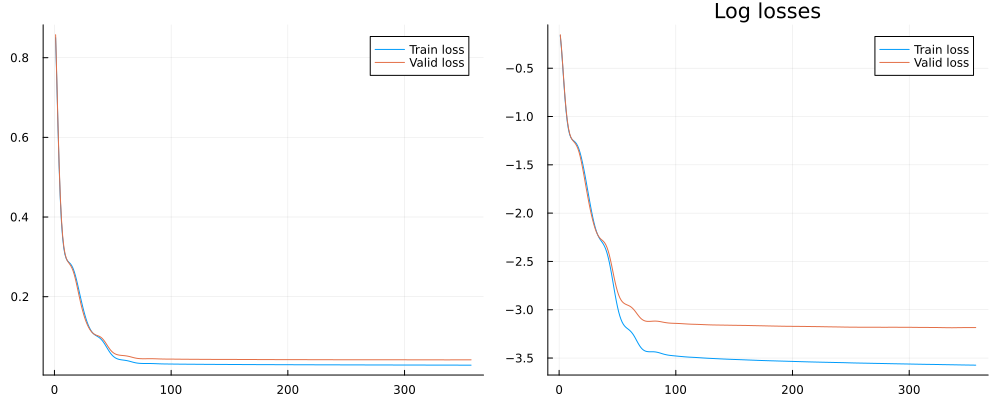

In [77]:
p11 = plot([losses11 losses12], labels=["Train loss" "Valid loss"])
p12 = plot(log.([losses11 losses12]), labels=["Train loss" "Valid loss"], title="Log losses") # might help at some cases
plot(p11, p12, size=(1000,400))

The output provided is from a one-sample Anderson-Darling test, which is used to assess whether a sample comes from a specified distribution. The test strongly rejects the null hypothesis, indicating that the sample does not come from the normal distribution.

In [42]:
using Distributions

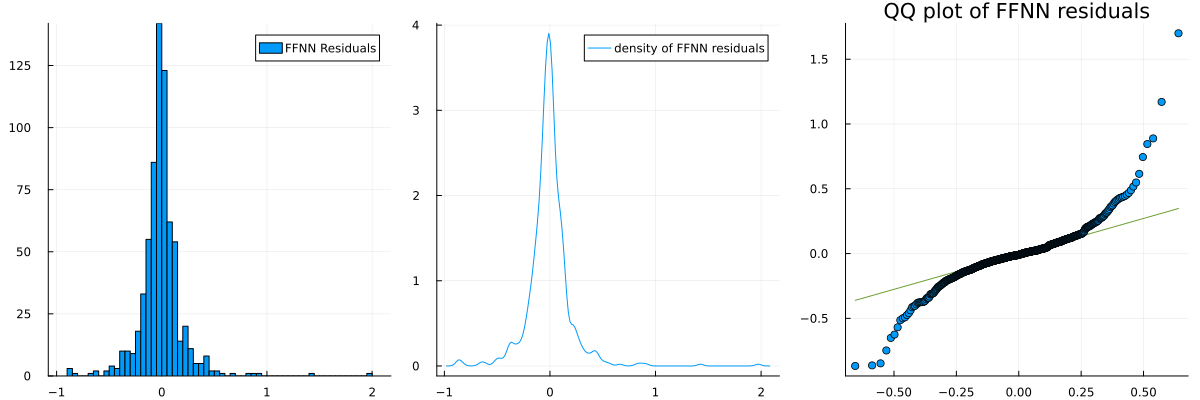

In [78]:
FFNN_resid = yv_std - FFNN(xv_std)
FFNN_quantiles = quantile(Normal(), LinRange(0, 1, length(FFNN_resid)))

qq1 = histogram(FFNN_resid', label = "FFNN Residuals")
qq2 = density(FFNN_resid', label="density of FFNN residuals")
qq3 = qqnorm(vec(FFNN_resid), qqline = :R, title = "QQ plot of FFNN residuals")
plot(qq1, qq2, qq3, layout=(1, 3), size=(1200, 400))

## RNN

In [79]:
xt_rnn = reshape(xt_std, 3, 1, :)
yt_rnn = reshape(yt_std, 1, 1, :)
xv_rnn = reshape(xv_std, 3, 1, :)
yv_rnn = reshape(yv_std, 1, 1, :);

Each "slice" along the third axis represents a sequence of length 3 for x and 1 for y, and the second dimension is used for processing elements within the sequence independently. This reshaping is often used in RNNs where the input is organized as sequences of data, and the network processes each sequence element iteratively. 

In [80]:
size(xt_std), size(yt_std)

((3, 2750), (1, 2750))

In [81]:
size(xt_rnn), size(yt_rnn)

((3, 1, 2750), (1, 1, 2750))

We now see the transformed 3D shape. 

In [82]:
mo1, mb1, lt1, lv1 = trainW4(xt_rnn, yt_rnn, xv_rnn, yv_rnn; nodes=[100, 50, 30], eta=0.001,
n_epochs=500, verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0);

Epoch [1/500] 	 Training Loss 0.61 	 Validation Loss 0.64


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 4


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 5


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 6


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 21


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 22


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 23


Epoch [31/500] 	 Training Loss 0.08 	 Validation Loss 0.09


Epoch [61/500] 	 Training Loss 0.06 	 Validation Loss 0.07


Epoch [91/500] 	 Training Loss 0.05 	 Validation Loss 0.06


Epoch [121/500] 	 Training Loss 0.04 	 Validation Loss 0.06


Epoch [151/500] 	 Training Loss 0.04 	 Validation Loss 0.05


Epoch [181/500] 	 Training Loss 0.04 	 Validation Loss 0.05


Epoch [211/500] 	 Training Loss 0.03 	 Validation Loss 0.05


Epoch [241/500] 	 Training Loss 0.03 	 Validation Loss 0.04


Epoch [271/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 273


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 274


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 275


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 281


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 282


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 285


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 286


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 289


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 290


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 297


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 298


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 299


  ⊚ Counted +1 in patience, 19/20 	 Epoch: 300


Epoch [301/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 305
 □ Epoch 305 	 Patience is LOST :) 


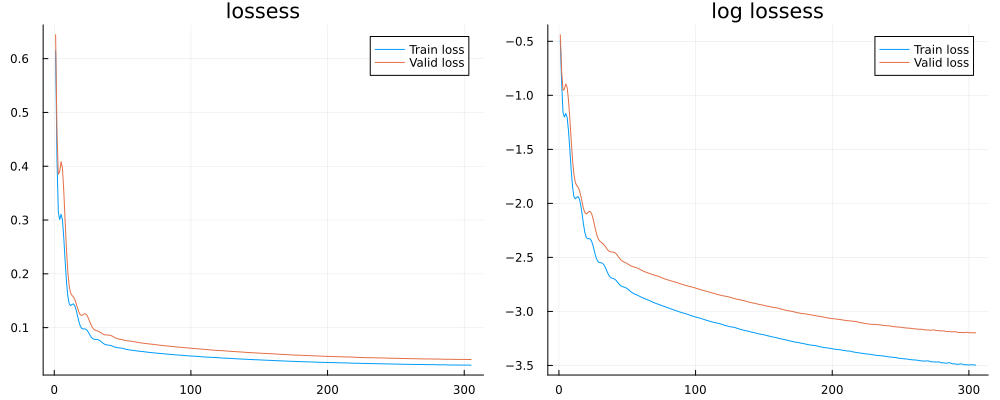

In [83]:
p3l = plot([lt1 lv1], labels=["Train loss" "Valid loss"], title = "lossess")
p4l = plot(log.([lt1 lv1]), labels=["Train loss" "Valid loss"], title = "log lossess")
plot(p3l, p4l, size=(1000,400))

In [84]:
Flux.reset!(mo1) # reset hidden
mo1(xt_rnn) # warm-up model
yhat_mo1_valid = mo1(xv_rnn) |> vec;

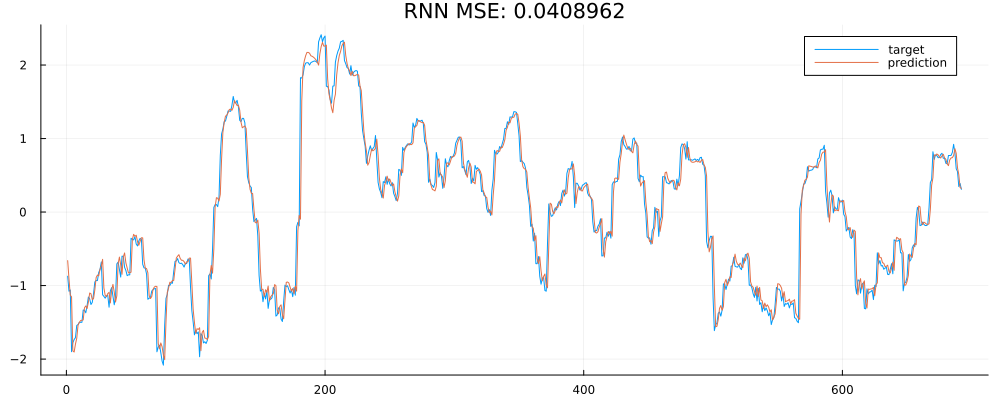

In [85]:
pred_fit = mo1(xv_rnn)
plt_vld = plot(yv_rnn |> vec; label="target")
plt_vld = plot!(pred_fit |> vec; label="prediction", title="RNN MSE: $(Flux.mse(pred_fit, yv_rnn))", size = (1000,400))

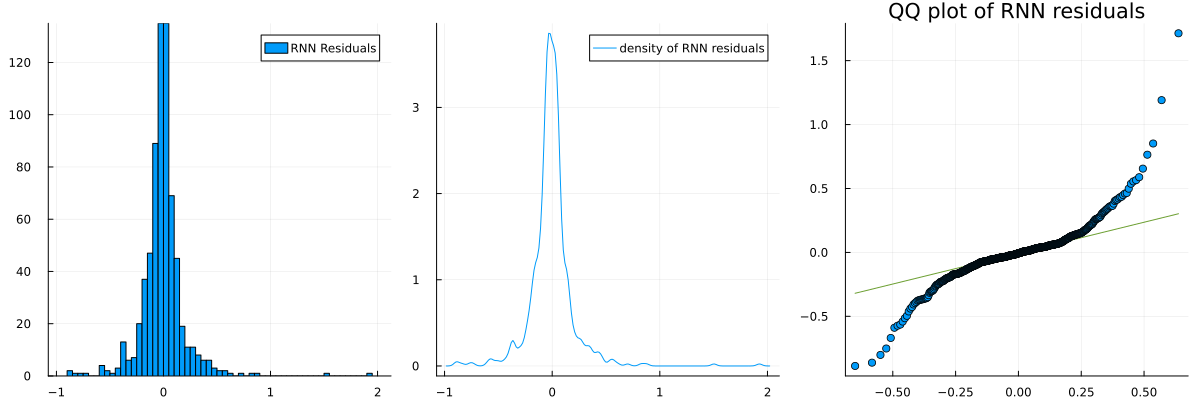

In [86]:
RNN_resid = yv_rnn .- reshape(yhat_mo1_valid, size(yv_rnn))
RNN_resid = dropdims(RNN_resid, dims=(1, 2))

qq1 = histogram(RNN_resid, label = "RNN Residuals")
qq2 = density(RNN_resid, label="density of RNN residuals")
qq3 = qqnorm(RNN_resid, qqline = :R, title = "QQ plot of RNN residuals")

plot(qq1, qq2, qq3, layout=(1, 3), size=(1200, 400))

---

## OLS

In [96]:
beta_har = OLSestimatorconst(yt_std', xt_std')

4×1 Matrix{Float64}:
  2.9698297982348507e-6
  1.0740930082189382
 -0.07121274460460772
 -0.023525344859972354

In [98]:
yhat_beta = [ones(size(xv_std',1)) xv_std'] * beta_har;

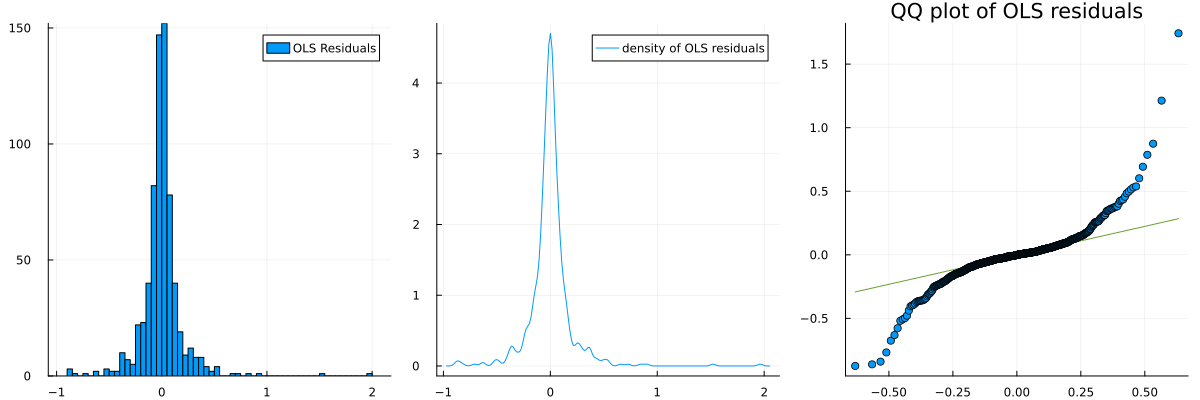

In [99]:
OLS_resid = yv_std' .- yhat_beta

qq1 = histogram(OLS_resid, label = "OLS Residuals")
qq2 = density(OLS_resid, label="density of OLS residuals")
qq3 = qqnorm(vec(OLS_resid), qqline = :R, title = "QQ plot of OLS residuals")

plot(qq1, qq2, qq3, layout=(1, 3), size=(1200, 400))

---

## Comparison

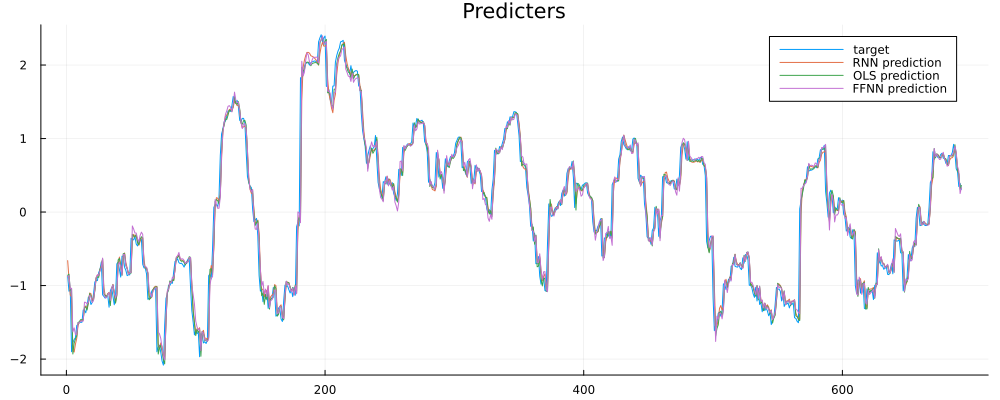

In [100]:
pred_fit = mo1(xv_rnn)
plt_vld = plot(yv_rnn |> vec; label="target")
plt_vld = plot!(pred_fit |> vec; label="RNN prediction", title="Predicters")
plt_vld = plot!(yhat_beta; label="OLS prediction", size = (1000,400))
plt_vld = plot!(FFNN(xv_std)'; label = "FFNN prediction")

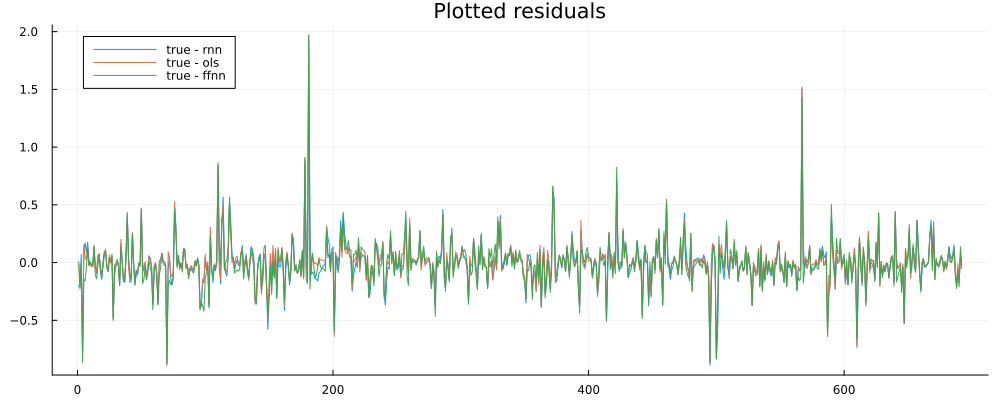

In [101]:
plot(yv_rnn[:] .- pred_fit[:], label="true - rnn")
plot!(yv_rnn[:]  .- yhat_beta, label="true - ols")
plot!(yv_rnn[:] .- FFNN(xv_std)[:], label="true - ffnn", size = (1000, 400), title = "Plotted residuals")


In [102]:
FFNN_MSE_t = Flux.Losses.mse(FFNN(xt_std),yt_std)
FFNN_MSE_v = Flux.Losses.mse(FFNN(xv_std),yv_std)
RNN_MSE_t = Flux.mse(mo1(xt_rnn), yt_rnn)
RNN_MSE_v = Flux.mse(mo1(xv_rnn), yv_rnn)
y_beta = [ones(size(xt_std',1)) xt_std'] * beta_har;
OLS_MSE_t = Flux.mse(y_beta, yt_std')
OLS_MSE_v = Flux.mse(yhat_beta, yv_std')

0.03932147589317962

In [103]:
analysis = DataFrame(
    Model = ["OLS", "FFNN", "RNN"],
    MSE_t = [OLS_MSE_t, FFNN_MSE_t, RNN_MSE_t],
    MSE_v = [OLS_MSE_v, FFNN_MSE_v, RNN_MSE_v]
)

# Display the DataFrame
display(analysis)

3×3 DataFrame
 Row │ Model   MSE_t      MSE_v     
     │ String  Float64    Float64   
─────┼──────────────────────────────
   1 │ OLS     0.0294899  0.0393215
   2 │ FFNN    0.0280571  0.0414082
   3 │ RNN     0.0303228  0.0408503

---

## Ensemble

In [123]:
n_ensembles = 5
arr_models = []
ens_loss_t = []
ens_loss_v = []
for iens in 1:n_ensembles
    println("> Running ensemble $iens")
    @time mo0, mb0, lt0, lv0 = trainW4(xt_rnn, yt_rnn, xv_rnn, yv_rnn; nodes=[100, 50, 30], eta=0.001,
    n_epochs=500, verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0)
    # _ saving
    push!(arr_models, mb0) # saving the best model for each ensemble
    push!(ens_loss_t, lt0)
    push!(ens_loss_v, lv0)
end

> Running ensemble 1


Epoch [1/500] 	 Training Loss 0.78 	 Validation Loss 0.78


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 6


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 7


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 8


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 24


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 25


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 26


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 27


Epoch [31/500] 	 Training Loss 0.08 	 Validation Loss 0.1


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 41


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 42


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 43


Epoch [61/500] 	 Training Loss 0.06 	 Validation Loss 0.08


Epoch [91/500] 	 Training Loss 0.05 	 Validation Loss 0.07


Epoch [121/500] 	 Training Loss 0.05 	 Validation Loss 0.06


Epoch [151/500] 	 Training Loss 0.04 	 Validation Loss 0.06


Epoch [181/500] 	 Training Loss 0.04 	 Validation Loss 0.05


Epoch [211/500] 	 Training Loss 0.04 	 Validation Loss 0.05


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 226


Epoch [241/500] 	 Training Loss 0.03 	 Validation Loss 0.05


Epoch [271/500] 	 Training Loss 0.03 	 Validation Loss 0.04


Epoch [301/500] 	 Training Loss 0.03 	 Validation Loss 0.04


Epoch [331/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 356


Epoch [361/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 364


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 365


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 369


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 370


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 373


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 374


  ⊚ Counted +1 in patience, 19/20 	 Epoch: 375


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 383
 □ Epoch 383 	 Patience is LOST :) 
146.420691 seconds (144.47 M allocations: 374.552 GiB, 38.06% gc time)
> Running ensemble 2


Epoch [1/500] 	 Training Loss 0.43 	 Validation Loss 0.45


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 5


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 20


Epoch [31/500] 	 Training Loss 0.07 	 Validation Loss 0.09


Epoch [61/500] 	 Training Loss 0.05 	 Validation Loss 0.07


Epoch [91/500] 	 Training Loss 0.05 	 Validation Loss 0.06


Epoch [121/500] 	 Training Loss 0.04 	 Validation Loss 0.05


Epoch [151/500] 	 Training Loss 0.04 	 Validation Loss 0.05


Epoch [181/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 182


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 183


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 185


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 186


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 188


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 189


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 191


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 208


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 210


Epoch [211/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 213


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 214


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 215


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 216


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 223


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 227


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 240


Epoch [241/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 19/20 	 Epoch: 246


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 247
 □ Epoch 247 	 Patience is LOST :) 
 62.776438 seconds (93.17 M allocations: 241.551 GiB, 18.88% gc time)
> Running ensemble 3


Epoch [1/500] 	 Training Loss 0.76 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 5


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 6


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 21


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 22


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 23


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 24


Epoch [31/500] 	 Training Loss 0.08 	 Validation Loss 0.1


Epoch [61/500] 	 Training Loss 0.06 	 Validation Loss 0.08


Epoch [91/500] 	 Training Loss 0.05 	 Validation Loss 0.07


Epoch [121/500] 	 Training Loss 0.05 	 Validation Loss 0.06


Epoch [151/500] 	 Training Loss 0.04 	 Validation Loss 0.05


Epoch [181/500] 	 Training Loss 0.04 	 Validation Loss 0.05


Epoch [211/500] 	 Training Loss 0.04 	 Validation Loss 0.05


Epoch [241/500] 	 Training Loss 0.03 	 Validation Loss 0.04


Epoch [271/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 272


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 281


Epoch [301/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 302


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 314


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 315


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 316


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 317


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 322


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 328


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 329


Epoch [331/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 333


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 334


  ⊚ Counted +1 in patience, 19/20 	 Epoch: 335


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 341
 □ Epoch 341 	 Patience is LOST :) 
 85.234225 seconds (128.63 M allocations: 333.479 GiB, 23.18% gc time)
> Running ensemble 4


Epoch [1/500] 	 Training Loss 0.88 	 Validation Loss 0.92


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 5


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 22


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 23


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 24


Epoch [31/500] 	 Training Loss 0.09 	 Validation Loss 0.1


Epoch [61/500] 	 Training Loss 0.06 	 Validation Loss 0.07


Epoch [91/500] 	 Training Loss 0.05 	 Validation Loss 0.06


Epoch [121/500] 	 Training Loss 0.04 	 Validation Loss 0.06


Epoch [151/500] 	 Training Loss 0.04 	 Validation Loss 0.05


Epoch [181/500] 	 Training Loss 0.04 	 Validation Loss 0.05


Epoch [211/500] 	 Training Loss 0.04 	 Validation Loss 0.05


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 218


Epoch [241/500] 	 Training Loss 0.03 	 Validation Loss 0.05


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 252


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 253


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 254


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 257


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 261


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 262


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 263


Epoch [271/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 279


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 282


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 283


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 299


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 300


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 301
Epoch [301/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 19/20 	 Epoch: 308


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 309
 □ Epoch 309 	 Patience is LOST :) 
 79.693160 seconds (116.56 M allocations: 302.184 GiB, 27.07% gc time)
> Running ensemble 5


Epoch [1/500] 	 Training Loss 1.16 	 Validation Loss 1.18


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 6


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 7


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 26


Epoch [31/500] 	 Training Loss 0.1 	 Validation Loss 0.12


Epoch [61/500] 	 Training Loss 0.06 	 Validation Loss 0.08


Epoch [91/500] 	 Training Loss 0.05 	 Validation Loss 0.07


Epoch [121/500] 	 Training Loss 0.05 	 Validation Loss 0.06


Epoch [151/500] 	 Training Loss 0.04 	 Validation Loss 0.06


Epoch [181/500] 	 Training Loss 0.04 	 Validation Loss 0.05


Epoch [211/500] 	 Training Loss 0.04 	 Validation Loss 0.05


Epoch [241/500] 	 Training Loss 0.04 	 Validation Loss 0.05


Epoch [271/500] 	 Training Loss 0.03 	 Validation Loss 0.05


Epoch [301/500] 	 Training Loss 0.03 	 Validation Loss 0.04


Epoch [331/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 344


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 345


Epoch [361/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 362


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 363


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 389


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 390


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 391
Epoch [391/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 392


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 393


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 406


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 407


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 408


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 418


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 419


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 421
Epoch [421/500] 	 Training Loss 0.03 	 Validation Loss 0.04


  ⊚ Counted +1 in patience, 19/20 	 Epoch: 426


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 427
 □ Epoch 427 	 Patience is LOST :) 
123.021436 seconds (161.06 M allocations: 417.582 GiB, 33.47% gc time)


In [124]:
arr_models

5-element Vector{Any}:
 Chain(Recur(LSTMCell(3 => 100)), Dropout(0.1), Dense(100 => 50), Dropout(0.1), Dense(50 => 1))  # 46_901 parameters, plus 200 non-trainable
 Chain(Recur(LSTMCell(3 => 100)), Dropout(0.1), Dense(100 => 50), Dropout(0.1), Dense(50 => 1))  # 46_901 parameters, plus 200 non-trainable
 Chain(Recur(LSTMCell(3 => 100)), Dropout(0.1), Dense(100 => 50), Dropout(0.1), Dense(50 => 1))  # 46_901 parameters, plus 200 non-trainable
 Chain(Recur(LSTMCell(3 => 100)), Dropout(0.1), Dense(100 => 50), Dropout(0.1), Dense(50 => 1))  # 46_901 parameters, plus 200 non-trainable
 Chain(Recur(LSTMCell(3 => 100)), Dropout(0.1), Dense(100 => 50), Dropout(0.1), Dense(50 => 1))  # 46_901 parameters, plus 200 non-trainable

Plotting coefficients of the first model

In [125]:
m_pars = Flux.params(arr_models[1]) |> collect .|> vec

9-element Vector{Vector{Float32}}:
 [0.07452101, 0.02260967, -0.08631858, -0.075991906, -0.0809148, -0.1045156, 0.069494344, 0.12997438, 0.06658348, -0.09699861  …  -0.106514774, -0.0058921813, 0.01224229, -0.08511795, 0.07402553, -0.0033350645, 0.0714328, -0.059972037, -0.088815294, -0.11648762]
 [0.05052743, 0.036195602, -0.08224673, -0.018069396, -0.0650924, -0.1553439, -0.014653287, -0.07690997, 0.085705966, -0.04706431  …  0.1561724, 0.040291525, 0.031313356, 0.09566738, 0.08446578, 0.020897452, -0.033238355, 0.01232807, 0.04658801, 0.10294299]
 [0.019684201, 0.06304075, -0.00014562365, 0.0038982157, 0.01820668, 0.059266318, 0.1074938, -0.012869915, 0.027105168, 0.0024008853  …  0.19797379, 0.015401569, 0.022471733, 0.055463254, 0.08836514, -0.014212021, 0.005470139, 0.019665014, 0.10338237, 0.01647996]
 [0.053181592, 0.04982364, -0.016067998, 0.025536753, 0.052763935, -0.004220541, 0.066689014, -0.07647246, -0.07720895, 0.08902024  …  -0.033238754, -0.032451406, 0.08640369, 0.011

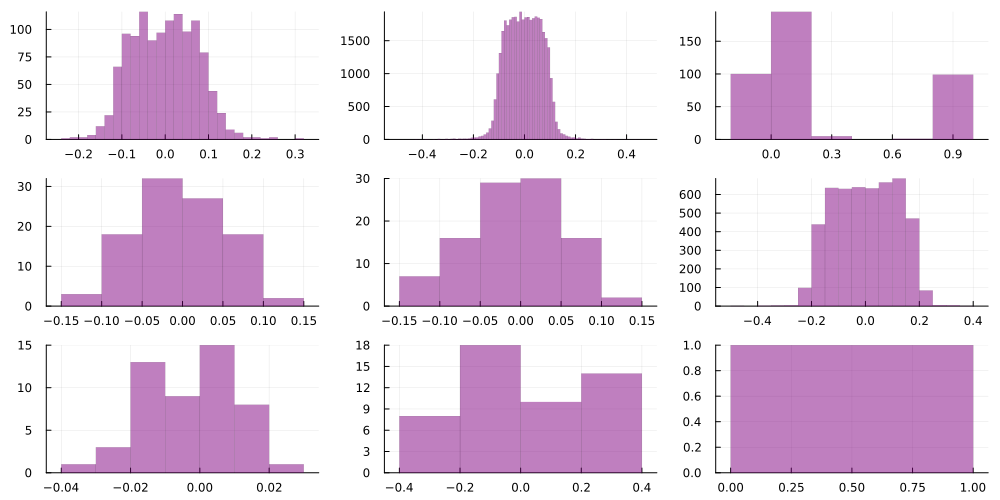

In [126]:
plot(histogram.(m_pars)..., line=(0), fill=(1, 0.5, :purple), legend=:none, size = (1000, 500))

Plot losses of all models in ensemble
Fit all models to see the output (still on validation which we use in training for stopping, for instance, thus not true Out-of-sample):

In [127]:
yhat_array = []
for m in arr_models
    Flux.reset!(m) # reset model
    m(xt_rnn) # warm-up the model for time step prior prediction
    push!(yhat_array, m(xv_rnn))
end

In [128]:
yhat_ensemble = mean(yhat_array) |> vec;

In [129]:
size(xtrain), size(ytrain)

((3, 2750), (1, 2750))

HAR prediction

In [130]:
har_coefs = OLSestimatorconst(yt_std', xt_std')
yhat_har_valid = (xv_std' * har_coefs[2:end]) .+ har_coefs[1];

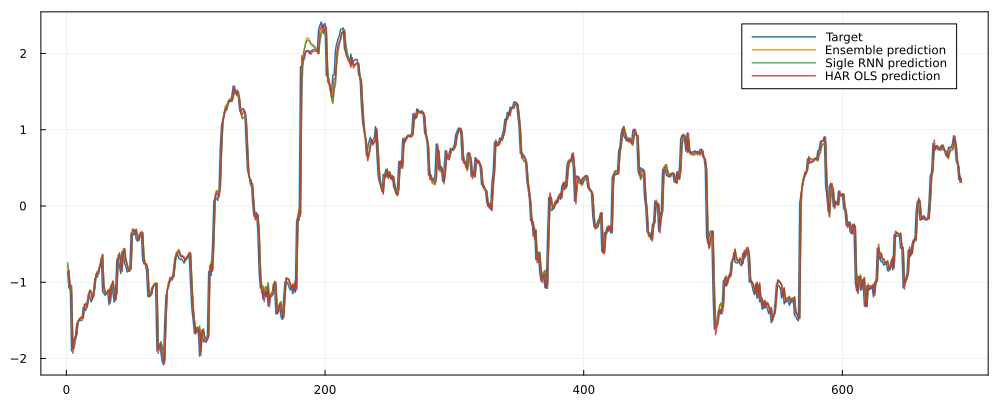

In [131]:
plot(yv_rnn |> vec, label="Target", size=(1000,400), framestyle=:box, line=(1.5, 1.0, :solid), palette=:tab10)
plot!(yhat_ensemble, label="Ensemble prediction", line=(1.5, 0.8, :solid))
plot!(yhat_mo1_valid, label="Sigle RNN prediction", line=(1.5, 0.8, :solid))
plot!(yhat_har_valid, label="HAR OLS prediction", line=(1.5, 0.8, :solid))

In [132]:
println(" HAR: ", Flux.mse(yhat_har_valid, yv_rnn |> vec), "\n",
    " Ens: ", Flux.mse(yhat_ensemble, yv_rnn |> vec), "\n",
    " M1:  ", Flux.mse(yhat_mo1_valid, yv_rnn |> vec), "\n")

 HAR: 0.039321475893179615
 Ens: 0.0406485
 M1:  0.040850326



Let's see the individual predictions:

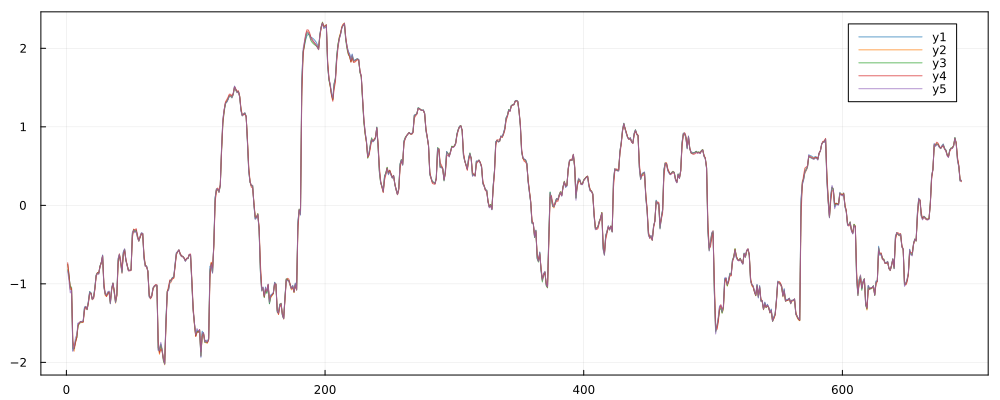

In [133]:
plot(yhat_array .|> vec, framestyle=:box, line=(1, 0.7, :solid), palette=:tab10, size=(1000,400))